In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
%matplotlib inline

### (1) Data Reading

In [2]:
tx = pd.read_csv(r"C:\Users\UTKARSH\Python\Imarticus_Class\Python\Class Files\MachineLearning\week9\Aug17\TaxiFare.csv")

In [3]:
tx.head()

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


### (2) Data Preparation

In [4]:
tx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   unique_id             50000 non-null  object 
 1   amount                50000 non-null  float64
 2   date_time_of_pickup   50000 non-null  object 
 3   longitude_of_pickup   50000 non-null  float64
 4   latitude_of_pickup    50000 non-null  float64
 5   longitude_of_dropoff  50000 non-null  float64
 6   latitude_of_dropoff   50000 non-null  float64
 7   no_of_passenger       50000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [5]:
tx["amount"].describe() 

count    50000.000000
mean        11.364171
std          9.685557
min         -5.000000
25%          6.000000
50%          8.500000
75%         12.500000
max        200.000000
Name: amount, dtype: float64

In [6]:
index_names = tx[tx["amount"]<2.5].index # we dropped it because the charge of taxi in new york can never be less than 2.5

In [7]:
index_names

Int64Index([2039, 2486, 2780, 10002, 13032, 27891, 28839, 36722, 42337, 47302], dtype='int64')

In [8]:
tx.drop(index_names,inplace=True)

#### Taxi fare amount can never be negative, also the charge of taxi can never be less than 2.5 in New York so dropping them. 

#### Checking the Presence of Outliers in Dataset

In [9]:
tx.describe(percentiles = [0.01,.02,.03,.04,.05,.1,.25,.4,.5,.75,.9,.95,.96,.98,.99]).T

,count,mean,std,min,1%,2%,3%,4%,5%,10%,25%,40%,50%,75%,90%,95%,96%,98%,99%,max
amount,49990.0,11.366813,9.684697,2.500000,3.300000,3.500000,3.700000,4.000000,4.100000,4.500000,6.000000,7.300000,8.500000,12.500000,20.500000,30.500000,33.566400,46.500000,52.000000,200.000000
longitude_of_pickup,49990.0,-72.509468,10.394880,-75.423848,-74.014436,-74.010456,-74.008734,-74.007742,-74.006816,-74.002780,-73.992062,-73.985837,-73.981840,-73.967155,-73.950996,-73.871348,-73.862870,-73.137393,0.000000,40.783472
latitude_of_pickup,49990.0,39.933598,6.225469,-74.006893,0.000000,40.578523,40.645443,40.681107,40.702132,40.717985,40.734883,40.746855,40.752679,40.767360,40.779778,40.787795,40.790614,40.799604,40.807129,401.083332
longitude_of_dropoff,49990.0,-72.505803,10.403539,-84.654241,-74.015120,-74.011755,-74.009840,-74.008284,-74.007275,-74.002710,-73.991152,-73.984217,-73.980082,-73.963588,-73.944750,-73.873280,-73.864201,-73.434436,0.000000,40.851027
latitude_of_dropoff,49990.0,39.926903,6.012677,-74.006377,0.000000,40.569767,40.646891,40.672764,40.686076,40.713277,40.734375,40.747609,40.753373,40.768166,40.782897,40.794074,40.798798,40.810249,40.832503,43.415190
no_of_passenger,49990.0,1.667914,1.289250,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,4.000000,5.000000,5.000000,5.000000,6.000000,6.000000


In [10]:
tx["X1"] = tx["latitude_of_pickup"]
tx["X2"] = tx["latitude_of_dropoff"]
tx["Y1"] = tx["longitude_of_pickup"]
tx["Y2"] = tx["longitude_of_dropoff"]

In [11]:
tx["Distance_Travel"] = np.sqrt((np.square(tx["X1"]-tx["X2"]))+(np.square(tx["Y1"]-tx["Y2"])))

#### We have used the Euclidean Distance formula to calculate the distance.

In [12]:
tx1=tx.drop(columns=["longitude_of_pickup","latitude_of_pickup","longitude_of_dropoff","latitude_of_dropoff"])

In [13]:
tx1[["date","Time","Zone"]]=tx1["date_time_of_pickup"].str.split(pat=" ",n=-1 , expand=True)
#splitting the date_time_of_pickup in separate columns.

In [14]:
tx2 = tx1.copy()

In [15]:
tx2["amount"] = np.where(tx2["amount"]>=52, 52, tx2["amount"])
tx2["no_of_passenger"] = np.where(tx2["no_of_passenger"]>=5, 4, tx2["no_of_passenger"])
tx2["Distance_Travel"] = np.where(tx2["Distance_Travel"]>=0.228218, 0.228218, tx2["Distance_Travel"])

In [16]:
tx2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49990 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   unique_id            49990 non-null  object 
 1   amount               49990 non-null  float64
 2   date_time_of_pickup  49990 non-null  object 
 3   no_of_passenger      49990 non-null  int64  
 4   X1                   49990 non-null  float64
 5   X2                   49990 non-null  float64
 6   Y1                   49990 non-null  float64
 7   Y2                   49990 non-null  float64
 8   Distance_Travel      49990 non-null  float64
 9   date                 49990 non-null  object 
 10  Time                 49990 non-null  object 
 11  Zone                 49990 non-null  object 
dtypes: float64(6), int64(1), object(5)
memory usage: 5.0+ MB


In [17]:
tx2["date"] = pd.to_datetime(tx2["date"])
tx2["date_time_of_pickup"] = pd.to_datetime(tx2["date_time_of_pickup"])
#Changig the type from object to datetime.

In [18]:
tx2["hours"] = tx2["date_time_of_pickup"].dt.hour
tx2["min"] = tx2["date_time_of_pickup"].dt.minute
tx2["second"] = tx2["date_time_of_pickup"].dt.second
tx2["year"] = tx2["date_time_of_pickup"].dt.year
tx2["day_of_the_month"] = tx2["date_time_of_pickup"].dt.day
#Extracting some features from date_time_of_pickup

In [19]:
def time_of_day(x):
    if x in range(6,12):
        return "Morning"
    elif x in range(12,17):
        return "Afternoon"
    elif x in range(17,21):
        return "Evening"
    else:
        return "Night"

In [20]:
tx2["time_of_day"] = tx2["hours"].apply(time_of_day)

In [21]:
tx2["day"] = tx2["date_time_of_pickup"].dt.day_name()
tx2["day_no"] = tx2["date_time_of_pickup"].dt.weekday

In [22]:
# Remove latitude and longtiude outliers
tx2 = tx2.loc[tx2['X1'].between(40, 42)]
tx2 = tx2.loc[tx2['Y1'].between(-75, -72)]
tx2 = tx2.loc[tx2['X2'].between(40, 42)]
tx2 = tx2.loc[tx2['Y2'].between(-75, -72)]
print(f'New number of observations: {tx2.shape[0]}')


New number of observations: 48944


In [23]:
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)


#### Using Manhattan Distance

In [24]:
tx2['manhattan_d'] = minkowski_distance(tx2['Y1'], 
                                       tx2['Y2'],
                                       tx2['X1'],
                                       tx2['X2'], 1)


#### Graphical Analysis

C:\Users\UTKARSH\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


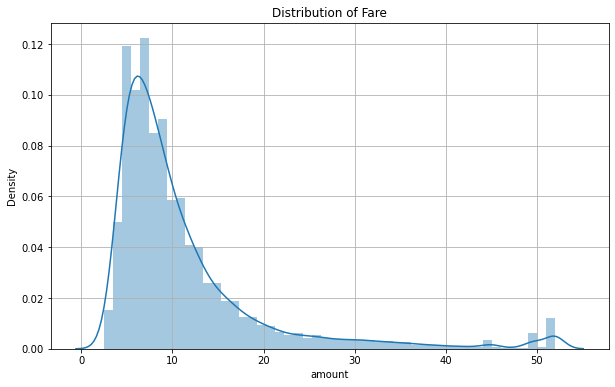

In [47]:
plt.figure(figsize = (10, 6))
sns.distplot(tx2['amount']);
plt.title('Distribution of Fare')
plt.grid()
plt.savefig('Distribution of Fare.jpg')

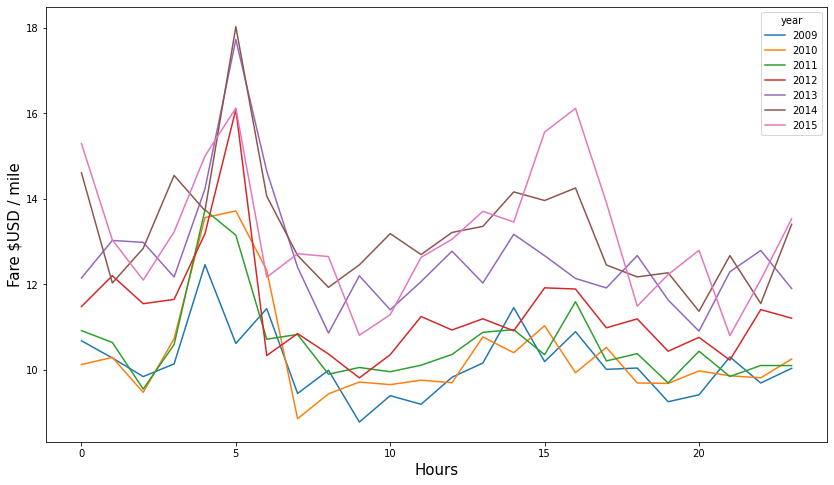

In [49]:
tx2.pivot_table(index='hours', columns='year', values="amount",aggfunc="mean").plot(figsize=(14,8))
plt.xlabel("Hours",fontsize=(15))
plt.ylabel('Fare $USD / mile',fontsize=(15))
plt.savefig('Fare $USD_mile.jpg')


In [27]:
tx2.head()

,unique_id,amount,date_time_of_pickup,no_of_passenger,X1,X2,Y1,Y2,Distance_Travel,date,...,Zone,hours,min,second,year,day_of_the_month,time_of_day,day,day_no,manhattan_d
0,26:21.0,4.5,2009-06-15 17:26:21+00:00,1,40.721319,40.712278,-73.844311,-73.841610,0.009436,2009-06-15,...,UTC,17,26,21,2009,15,Evening,Monday,0,0.011742
1,52:16.0,16.9,2010-01-05 16:52:16+00:00,1,40.711303,40.782004,-74.016048,-73.979268,0.079696,2010-01-05,...,UTC,16,52,16,2010,5,Afternoon,Tuesday,1,0.107481
2,35:00.0,5.7,2011-08-18 00:35:00+00:00,2,40.761270,40.750562,-73.982738,-73.991242,0.013674,2011-08-18,...,UTC,0,35,0,2011,18,Night,Thursday,3,0.019212
3,30:42.0,7.7,2012-04-21 04:30:42+00:00,1,40.733143,40.758092,-73.987130,-73.991567,0.025340,2012-04-21,...,UTC,4,30,42,2012,21,Night,Saturday,5,0.029386
4,51:00.0,5.3,2010-03-09 07:51:00+00:00,1,40.768008,40.783762,-73.968095,-73.956655,0.019470,2010-03-09,...,UTC,7,51,0,2010,9,Morning,Tuesday,1,0.027194


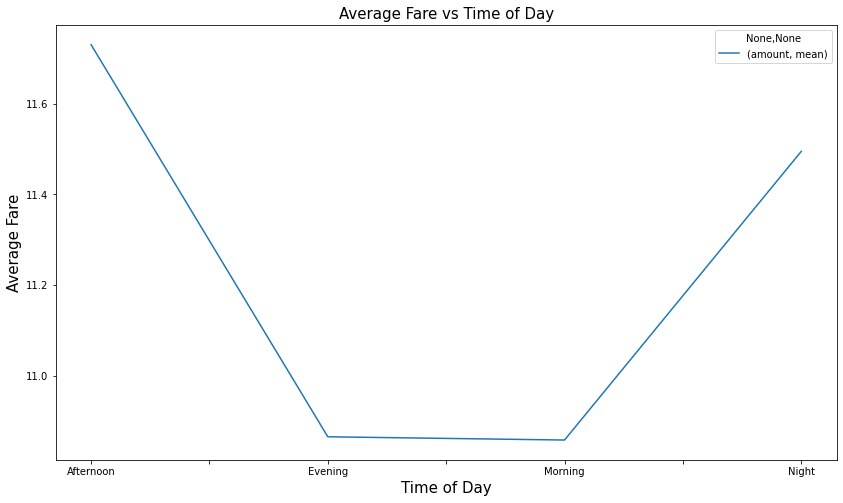

In [50]:
tx2.groupby(tx2["time_of_day"]).agg({"amount":["mean"]}).plot(figsize=(14,8))
plt.title("Average Fare vs Time of Day",fontsize=(15))
plt.xlabel("Time of Day",fontsize=(15))
plt.ylabel('Average Fare',fontsize=(15))
plt.savefig("Average_Fare_vs_Time_of_Day.jpg")

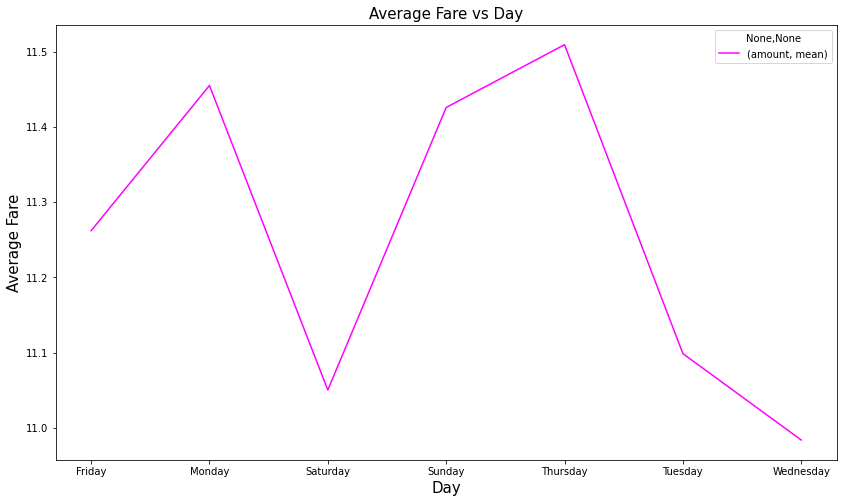

In [51]:
tx2.groupby(tx2["day"]).agg({"amount":["mean"]}).plot(figsize=(14,8),color="magenta")
plt.title("Average Fare vs Day",fontsize=(15))
plt.xlabel("Day",fontsize=(15))
plt.ylabel('Average Fare',fontsize=(15))
plt.savefig("Average_Fare_vs_Day.jpg")

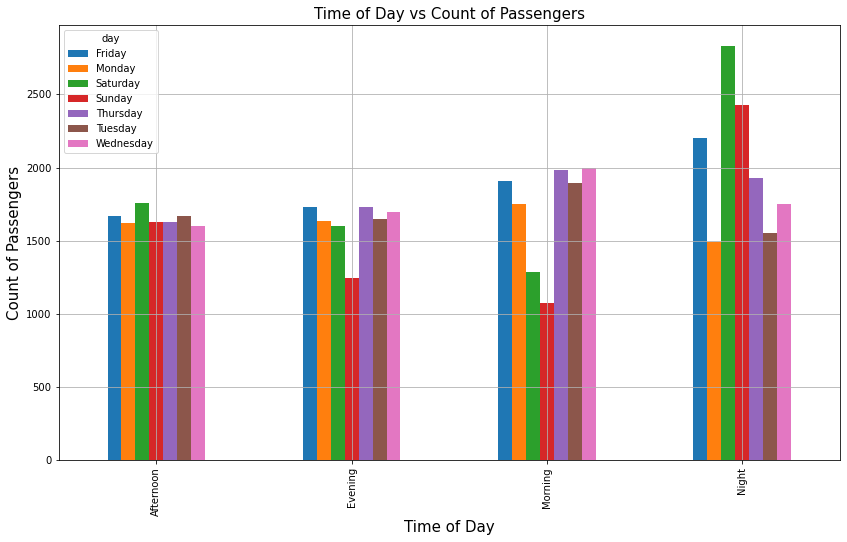

In [52]:
tx2.pivot_table(index='time_of_day', columns='day', values="no_of_passenger",aggfunc="count").plot(figsize=(14,8),kind='bar')
plt.title("Time of Day vs Count of Passengers",fontsize=(15))
plt.xlabel("Time of Day",fontsize=(15))
plt.ylabel('Count of Passengers',fontsize=(15));
plt.grid()
plt.savefig("Time_of_Day_vs_Count_of_Passengers.jpg")

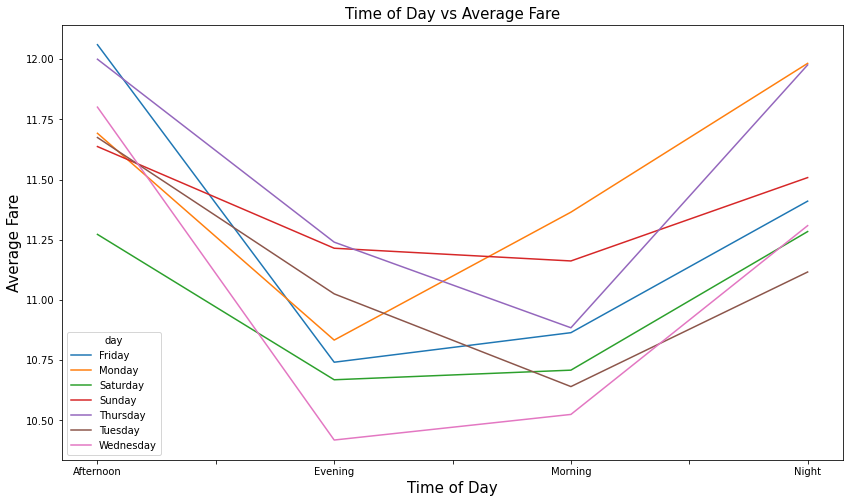

In [53]:
tx2.pivot_table(index='time_of_day', columns='day', values="amount",aggfunc="mean").plot(figsize=(14,8))
plt.title("Time of Day vs Average Fare",fontsize=(15))
plt.xlabel("Time of Day",fontsize=(15))
plt.ylabel('Average Fare',fontsize=(15))
plt.savefig("Time_of_Day_vs_Average_Fare.jpg")

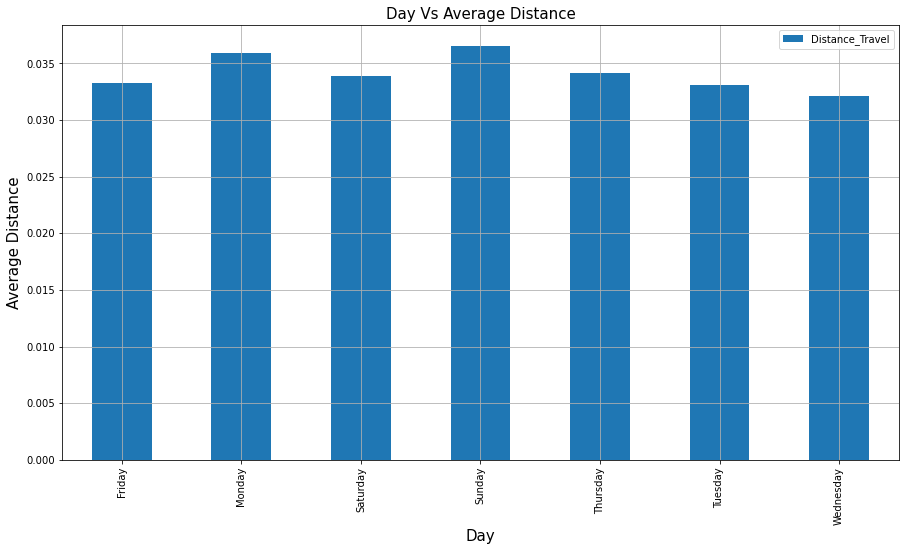

In [54]:
tx2.pivot_table(index="day",values= "Distance_Travel",aggfunc="mean").plot(figsize=(15,8),kind='bar')
plt.title("Day Vs Average Distance",fontsize=(15))
plt.xlabel("Day",fontsize=(15))
plt.ylabel('Average Distance',fontsize=(15));
plt.grid()
plt.savefig("Day Vs Average Distance.jpg")

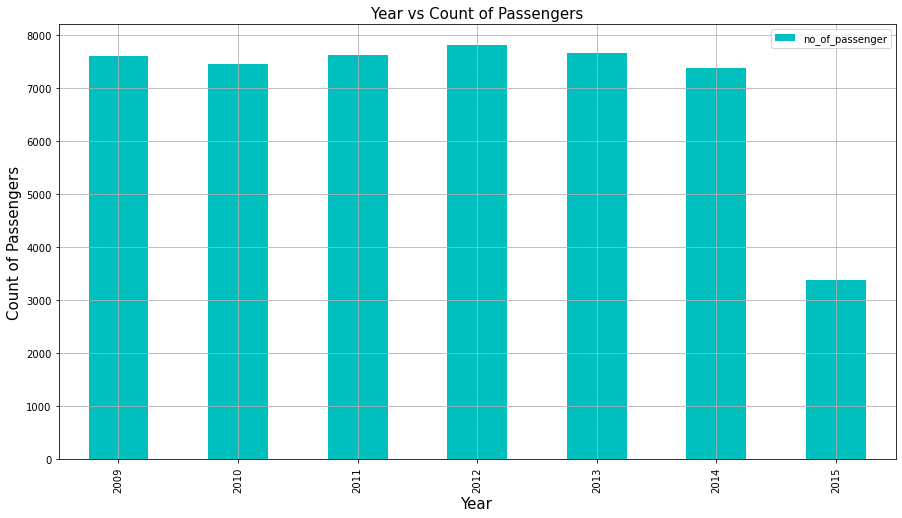

In [55]:
tx2.pivot_table(index="year",values= "no_of_passenger",aggfunc="count").plot(figsize=(15,8), kind='bar',color='c')
plt.title("Year vs Count of Passengers",fontsize=(15))
plt.xlabel("Year",fontsize=(15))
plt.ylabel('Count of Passengers',fontsize=(15));
plt.grid()
plt.savefig("Year vs Count of Passengers.jpg")

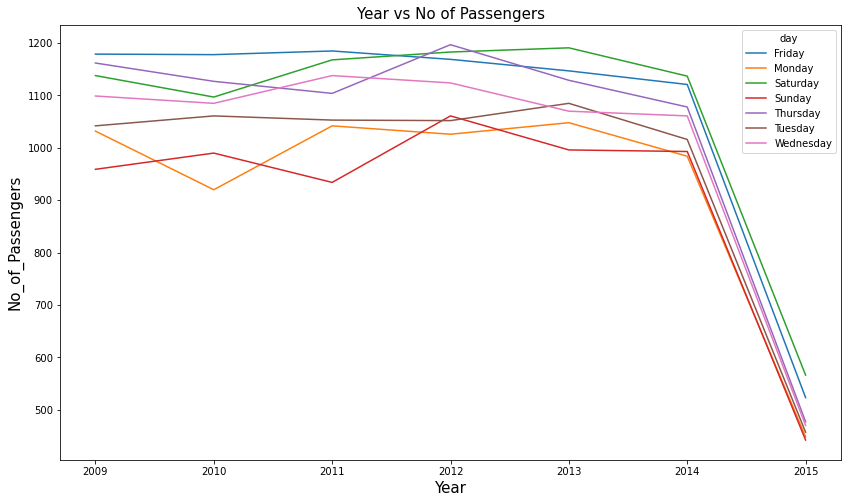

In [57]:
tx2.pivot_table(index="year",columns="day",values="no_of_passenger",aggfunc="count").plot(figsize=(14,8))
plt.title("Year vs No of Passengers",fontsize=(15))
plt.xlabel("Year",fontsize=(15))
plt.ylabel('No_of_Passengers',fontsize=(15))
plt.savefig("Year vs No of Passengers.jpg")


In [35]:
tx2.select_dtypes(include='O').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48944 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   unique_id    48944 non-null  object
 1   Time         48944 non-null  object
 2   Zone         48944 non-null  object
 3   time_of_day  48944 non-null  object
 4   day          48944 non-null  object
dtypes: object(5)
memory usage: 2.2+ MB


In [36]:
tx2.drop(columns=["unique_id","Time","Zone","date","min","second","date_time_of_pickup","X1","X2","Y1","Y2"],inplace =True)

In [37]:
# 1: Yes
# 0: No
# Is_Weekend - if day_no between (0,6) : 1
#              else i.e (1 to 5): 0
# Is_starting_of_month - day of month between (1-10)
# Is_middle_of_month - day of month between (15-20)
# Is_end_of_month - day of month between (20-31)


In [38]:
tx3 = pd.get_dummies(tx2,columns=["time_of_day","day"]) #Dummy Creation

In [39]:
tx3["Is_Weekend"] =np.where(tx3["day_no"].isin ([0,6]),1,0)
tx3["Is_starting_of_month"] = np.where(tx3["day_of_the_month"].isin ([1,2,3,4,5,6,7,8,9,10]),1,0)
tx3["Is_middle_of_month"] = np.where(tx3["day_of_the_month"].isin (range(11,21)),1,0)
tx3["Is_end_of_month"] = np.where(tx3["day_of_the_month"].isin (range(21,32)),1,0)
tx3["Is_leap_year"] = np.where((tx3["year"]%4 == 0),1,0)

In [40]:
tx3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48944 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount                 48944 non-null  float64
 1   no_of_passenger        48944 non-null  int64  
 2   Distance_Travel        48944 non-null  float64
 3   hours                  48944 non-null  int64  
 4   year                   48944 non-null  int64  
 5   day_of_the_month       48944 non-null  int64  
 6   day_no                 48944 non-null  int64  
 7   manhattan_d            48944 non-null  float64
 8   time_of_day_Afternoon  48944 non-null  uint8  
 9   time_of_day_Evening    48944 non-null  uint8  
 10  time_of_day_Morning    48944 non-null  uint8  
 11  time_of_day_Night      48944 non-null  uint8  
 12  day_Friday             48944 non-null  uint8  
 13  day_Monday             48944 non-null  uint8  
 14  day_Saturday           48944 non-null  uint8  
 15  da

### (3) Applying Model

In [41]:
y = tx3["amount"]
X = tx3.drop(columns=["amount"])

#### Splitting the Data into Train and Test

In [42]:
X_train,X_test,y_train,y_test =train_test_split(X,y, test_size = 0.2 , random_state = 1)

#### Using RandomForest Regressor

In [43]:
rf2 = RandomForestRegressor()
rf2.fit(X_train,y_train)
print("Train R2", rf2.score(X_train,y_train))
print("Test R2",rf2.score(X_test,y_test))

Train R2 0.9760477070258881
Test R2 0.8172217374657045


In [44]:
param = {"n_estimators":[20,50],"criterion":['mse'] ,"max_depth": [3,5],"min_samples_split":[2,4],
                "min_samples_leaf":[2,4]}

rf3 = RandomForestRegressor()
Grid_search = GridSearchCV(estimator = rf3, param_grid=param,cv=5,verbose=1,n_jobs=-1)
Grid_search.fit(X_train,y_train)




Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'criterion': ['mse'], 'max_depth': [3, 5],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 4],
                         'n_estimators': [20, 50]},
             verbose=1)

In [45]:
print("Train R2", Grid_search.score(X_train,y_train))
print("Test R2",Grid_search.score(X_test,y_test))


Train R2 0.8281393064156878
Test R2 0.8211941599539258


In [46]:
print("MAE of Train: ", np.mean(np.abs((y_train-Grid_search.predict(X_train))) ))
print("MAE of Test: ", np.mean(np.abs((y_test-Grid_search.predict(X_test))) ))
print("RMSE of Train: ", np.sqrt(np.mean((y_train-Grid_search.predict(X_train))**2) ))
print("RMSE of Test: ", np.sqrt(np.mean((y_test-Grid_search.predict(X_test))**2) ))


MAE of Train:  2.0740174640094216
MAE of Test:  2.1095654969089037
RMSE of Train:  3.716537042527461
RMSE of Test:  3.774178799191011
